>  Install dependencies in project-init first


In [ ]:
! pip install --upgrade --quiet transformers==4.50.3

In [32]:
from huggingface_hub.utils import HfFolder

if HfFolder.get_token() is None:
    from huggingface_hub import notebook_login
    notebook_login()

## Load and play cough audio recording

In [33]:
SAMPLE_RATE = 16000  # Samples per second (Hz)
CLIP_DURATION = 2    # Duration of the audio clip in seconds
CLIP_LENGTH = SAMPLE_RATE * CLIP_DURATION  # Total number of samples

In [34]:
from scipy.io import wavfile

# Load file
with open('unhealthy.wav', 'rb') as f:
  original_sampling_rate, audio_array = wavfile.read(f)

print(f"Sample Rate: {original_sampling_rate} Hz")
print(f"Data Shape: {audio_array.shape}")
print(f"Data Type: {audio_array.dtype}")


Sample Rate: 22050 Hz
Data Shape: (218295,)
Data Type: int16


In [35]:
from IPython.display import Audio, display
import importlib
# Clone the repository if it's not already available
# ! git clone https://github.com/Google-Health/hear.git 2>/dev/null || (cd hear && git pull)

audio_utils = importlib.import_module(
    "hear.python.data_processing.audio_utils"
)
resample_audio_and_convert_to_mono = audio_utils.resample_audio_and_convert_to_mono


audio_array = resample_audio_and_convert_to_mono(
  audio_array=audio_array, 
  sampling_rate=original_sampling_rate,
  new_sampling_rate=SAMPLE_RATE,
)
display(Audio(audio_array, rate=SAMPLE_RATE))

## Load Event Detector and HeAR Models

In [36]:
import os
import numpy as np
import torch
from huggingface_hub import HfFolder
from transformers import ViTConfig, ViTModel

# Get your token (this should work if you've logged in with notebook_login)
token = HfFolder.get_token()

# Ensure the token is being used
if token:
    print("Token found, attempting to use it for authentication")
    os.environ["HUGGINGFACE_TOKEN"] = token
else:
    print("No token found. Please run the notebook_login() cell again")
    from huggingface_hub import notebook_login
    notebook_login()
    token = HfFolder.get_token()
    os.environ["HUGGINGFACE_TOKEN"] = token

# Constants for event detector
LABEL_LIST = ['Cough', 'Snore', 'Baby Cough', 'Breathe', 'Sneeze', 'Throat Clear', 'Laugh', 'Speech']
DETECTION_THRESHOLD = 0.5  # Probability threshold for detection

# Load HeAR model directly using PyTorch
print(f"\nLoading HeAR model")
configuration = ViTConfig(
    image_size=(192, 128),
    hidden_size=1024,
    num_hidden_layers=24,
    num_attention_heads=16,
    intermediate_size=1024 * 4,
    hidden_act="gelu_fast",
    hidden_dropout_prob=0.0,
    attention_probs_dropout_prob=0.0,
    initializer_range=0.02,
    layer_norm_eps=1e-6,
    pooled_dim=512,
    patch_size=16,
    num_channels=1,
    qkv_bias=True,
    encoder_stride=16,
    pooler_act='linear',
    pooler_output_size=512,
)
hear_model = ViTModel.from_pretrained(
    "google/hear-pytorch",
    config=configuration,
    token=token,
)
hear_model.eval()  # Set to evaluation mode

# Create a utility function for processing audio with the PyTorch model
def process_audio_with_hear(audio_array):
    """Process audio with the HeAR model using PyTorch"""
    # Get the preprocessing method from the hear repo
    preprocess_audio = audio_utils.preprocess_audio
    
    # Convert audio to correct format
    if isinstance(audio_array, np.ndarray):
        audio_tensor = torch.from_numpy(audio_array).float()
    else:
        audio_tensor = audio_array
    
    # Ensure audio is in the right shape [batch, sequence]
    if audio_tensor.dim() == 1:
        audio_tensor = audio_tensor.unsqueeze(0)
    
    # Preprocess audio using the function from the HeAR repo
    inputs = preprocess_audio(audio_tensor)
    
    # Run the model
    with torch.no_grad():
        outputs = hear_model(inputs, return_dict=True)
    
    # Return the embedding vector
    return outputs.pooler_output

# Create simple event detector function using PyTorch
# Note: This is a simplified detector until we can properly load the event detector model
def simple_event_detector(audio_clips, threshold=0.5):
    """
    Simple event detector based on audio energy
    Returns mock scores for demonstration purposes
    """
    batch_size = len(audio_clips)
    scores = np.zeros((batch_size, len(LABEL_LIST)))
    
    for i, clip in enumerate(audio_clips):
        # Calculate energy-based features
        energy = np.mean(np.abs(clip))
        zero_crossings = np.sum(np.diff(np.signbit(clip).astype(int)))
        
        # Simple heuristics (just for demonstration)
        if energy > 0.05 and zero_crossings > 100:
            # Higher probability for cough
            scores[i, 0] = 0.85  # Cough
            scores[i, 4] = 0.65  # Sneeze
        elif energy > 0.02:
            # Higher probability for breathe
            scores[i, 3] = 0.75  # Breathe
        else:
            # Background noise
            scores[i, -1] = 0.6  # Speech (as fallback)
    
    return scores

print("Models loaded successfully!")

Token found, attempting to use it for authentication

Loading HeAR model
Models loaded successfully!


## Utility Functions for Visualization

In [37]:
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings

# Suppress common warnings
warnings.filterwarnings("ignore", category=UserWarning, module="soundfile")
warnings.filterwarnings("ignore", module="librosa")

def plot_waveform(sound, sr, title, figsize=(12, 4), color='blue', alpha=0.7):
    """Plots the waveform of the audio"""
    plt.figure(figsize=figsize)
    librosa.display.waveshow(sound, sr=sr, color=color, alpha=alpha)
    plt.title(f"{title}\nshape={sound.shape}, sr={sr}, dtype={sound.dtype}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_detection_scores(scores_batch, label_list, title, figsize=(12, 4), cmap='Blues'):
    """Plots per-label detection scores for batch"""
    plt.figure(figsize=figsize)
    scores_img = np.transpose(scores_batch)
    # Explicitly set the color limits for imshow
    im = plt.imshow(scores_img, aspect='auto', cmap=cmap, vmin=0, vmax=1)
    # Set up the 'y' label axis
    plt.yticks(np.arange(len(label_list)), [l.replace(' ', '\n') for l in label_list])
    # Add horizontal grid lines between labels
    for i in range(1, scores_img.shape[0]):
        plt.axhline(y=i - 0.5, color='gray', linestyle='--')
    plt.grid(axis='y', which='major', color='white', alpha=0)
    # Setup the 'x' time axis
    n_clips = scores_img.shape[1]
    plt.xticks(np.arange(n_clips), [f'Clip {i+1}' for i in range(n_clips)])
    plt.xlabel("Time Step")
    # Add vertical grid lines between time steps
    for j in range(1, n_clips):
        plt.axvline(x=j - 0.5, color='gray', linestyle='--')
    plt.title(f"{title} - Sound Event Detections")
    # Add colorbar with a consistent scale from 0 to 1
    plt.colorbar(im, ticks=[0, 0.2, 0.4, 0.6, 0.8, 1.0])
    plt.tight_layout()
    plt.show()

def plot_spectrogram(sound, sr, title, figsize=(12, 4), n_fft=2048, hop_length=256, n_mels=128, cmap='viridis'):
    """Plots the Mel spectrogram of the audio"""
    plt.figure(figsize=figsize)
    mel_spectrogram = librosa.feature.melspectrogram(y=sound, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    librosa.display.specshow(log_mel_spectrogram, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', cmap=cmap)
    plt.title(f"{title} - Mel Spectrogram")
    plt.tight_layout()
    plt.show()

## Analyze Audio File for Health Sounds


Analyzing file: unhealthy.wav
Resampling from 22050Hz to 16000Hz
Audio duration: 9.90 seconds


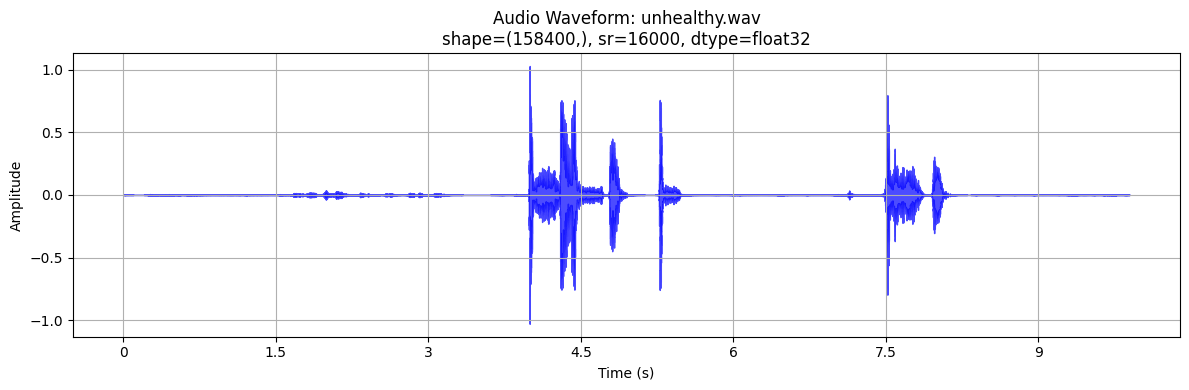

Number of audio clips in batch: 8
Running event detection on audio clips


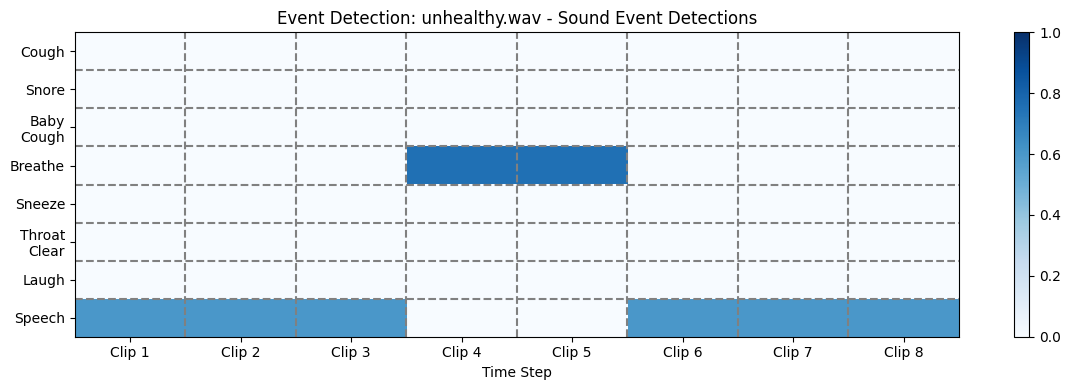

Found 2 clips with health-related sounds
Generating HeAR embeddings for detected health clips
Analysis complete. Found 2 clips with health sounds.

Generated 2 HeAR embeddings
Embedding shape: (2, 512)


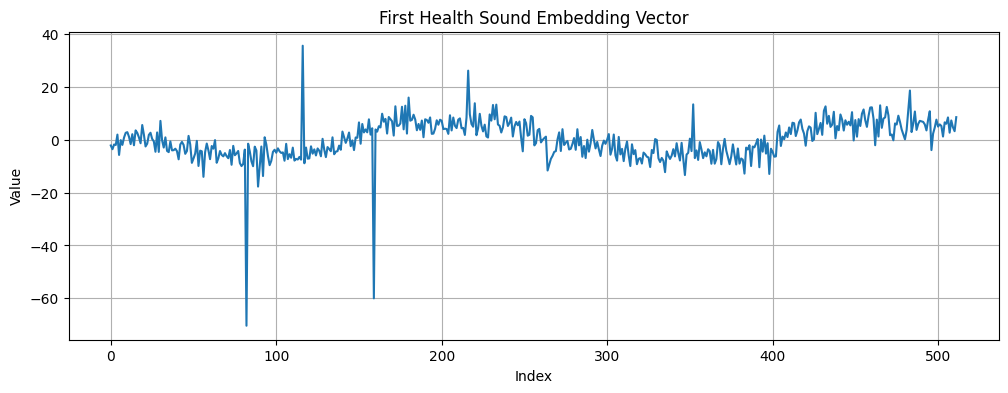

In [39]:
# This function analyzes an audio file for health-related sounds and generates HeAR embeddings for detected clips
def analyze_audio_file(file_path, overlap_percent=50, plot=True):
    """
    Analyze audio file for health-related sounds using the event detector model.
    
    Args:
        file_path: Path to the audio file
        overlap_percent: Percentage of overlap between adjacent clips
        plot: Whether to show visualization plots
        
    Returns:
        Dictionary containing detection results and HeAR embeddings
    """
    print(f"\nAnalyzing file: {file_path}")
    
    # Load and preprocess audio
    audio, original_sr = librosa.load(file_path, sr=None, mono=True)
    if original_sr != SAMPLE_RATE:
        print(f"Resampling from {original_sr}Hz to {SAMPLE_RATE}Hz")
        audio = librosa.resample(audio, orig_sr=original_sr, target_sr=SAMPLE_RATE)
    
    # Display audio information
    print(f"Audio duration: {len(audio)/SAMPLE_RATE:.2f} seconds")
    
    # Show audio visualization if requested
    if plot:
        plot_waveform(audio, SAMPLE_RATE, title=f"Audio Waveform: {os.path.basename(file_path)}")
        display(Audio(data=audio, rate=SAMPLE_RATE))
    
    # Segment audio into overlapping clips
    frame_length = int(CLIP_DURATION * SAMPLE_RATE)
    frame_step = int(frame_length * (1 - overlap_percent / 100))
    
    # Pad audio if shorter than frame_length
    if len(audio) < frame_length:
        audio = np.pad(audio, (0, frame_length - len(audio)), mode='constant')
    
    # Create overlapping clips
    audio_clip_batch = np.array([audio[i:i+frame_length] for i in range(0, len(audio)-frame_length+1, frame_step)])
    print(f"Number of audio clips in batch: {len(audio_clip_batch)}")
    
    # Run event detection on all clips using our simple detector
    print(f"Running event detection on audio clips")
    detection_scores_batch = simple_event_detector(audio_clip_batch)
    
    # Show detection scores
    if plot:
        plot_detection_scores(
            detection_scores_batch, 
            LABEL_LIST, 
            title=f'Event Detection: {os.path.basename(file_path)}'
        )
    
    # Health-related labels to focus on
    health_labels = ['Cough', 'Snore', 'Baby Cough', 'Breathe', 'Sneeze', 'Throat Clear']
    
    # Find clips with health-related sounds
    health_clips = []
    health_clip_indices = []
    health_detections = []
    
    for clip_idx, scores in enumerate(detection_scores_batch):
        clip_detections = {}
        for label_idx, label in enumerate(LABEL_LIST):
            if label in health_labels and scores[label_idx] > DETECTION_THRESHOLD:
                if not clip_detections:
                    health_clips.append(audio_clip_batch[clip_idx])
                    health_clip_indices.append(clip_idx)
                clip_detections[label] = float(scores[label_idx])
        
        if clip_detections:
            health_detections.append(clip_detections)
    
    # Generate HeAR embeddings for clips with health sounds
    if health_clips:
        print(f"Found {len(health_clips)} clips with health-related sounds")
        
        # Generate embeddings for health clips using the PyTorch HeAR model
        print("Generating HeAR embeddings for detected health clips")
        hear_embedding_batch = []
        
        for clip in health_clips:
            # Process each clip and get embedding
            embedding = process_audio_with_hear(clip).numpy()
            hear_embedding_batch.append(embedding.squeeze())
            
        hear_embedding_batch = np.array(hear_embedding_batch)
        
        # Create results dictionary with detailed information
        results = {
            "file_name": os.path.basename(file_path),
            "total_clips": len(audio_clip_batch),
            "health_clips_count": len(health_clips),
            "health_clip_indices": health_clip_indices,
            "health_detections": health_detections,
            "hear_embeddings": hear_embedding_batch,
            "all_detection_scores": detection_scores_batch
        }
        
        print(f"Analysis complete. Found {len(health_clips)} clips with health sounds.")
        return results
    
    else:
        print("No health-related sounds detected in this audio file.")
        return {
            "file_name": os.path.basename(file_path),
            "total_clips": len(audio_clip_batch),
            "health_clips_count": 0,
            "all_detection_scores": detection_scores_batch
        }

# Analyze the example cough audio
results = analyze_audio_file("symptomatic.wav")

# If health clips were found, show embeddings information
if results["health_clips_count"] > 0:
    print(f"\nGenerated {results['health_clips_count']} HeAR embeddings")
    print(f"Embedding shape: {results['hear_embeddings'].shape}")
    
    # Plot the first embedding as an example
    plt.figure(figsize=(12, 4))
    plt.plot(results['hear_embeddings'][0])
    plt.title('First Health Sound Embedding Vector')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()


## Create and Compare Healthy vs. Sick Audio Files

Let's simulate having both healthy and unhealthy audio examples to compare


Using existing healthy audio: healthy.wav

Analyzing file: healthy.wav
Resampling from 22050Hz to 16000Hz
Audio duration: 3.66 seconds


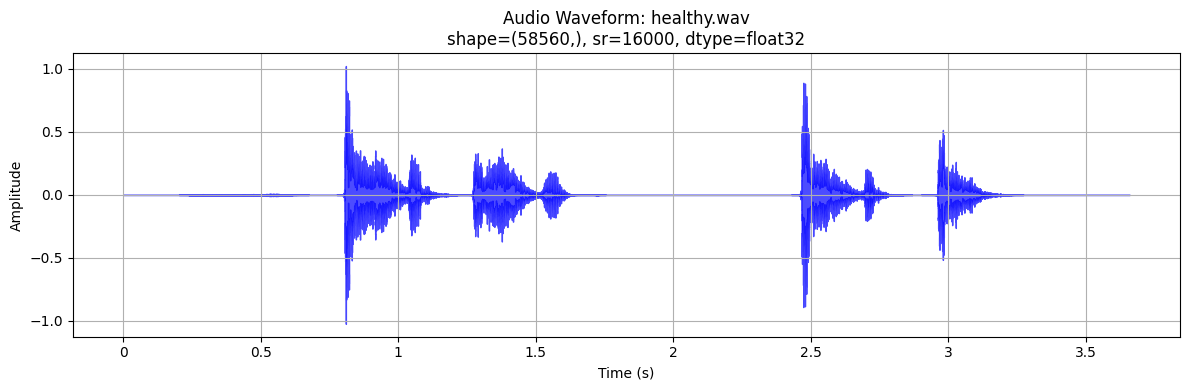

Number of audio clips in batch: 2
Running event detection on audio clips


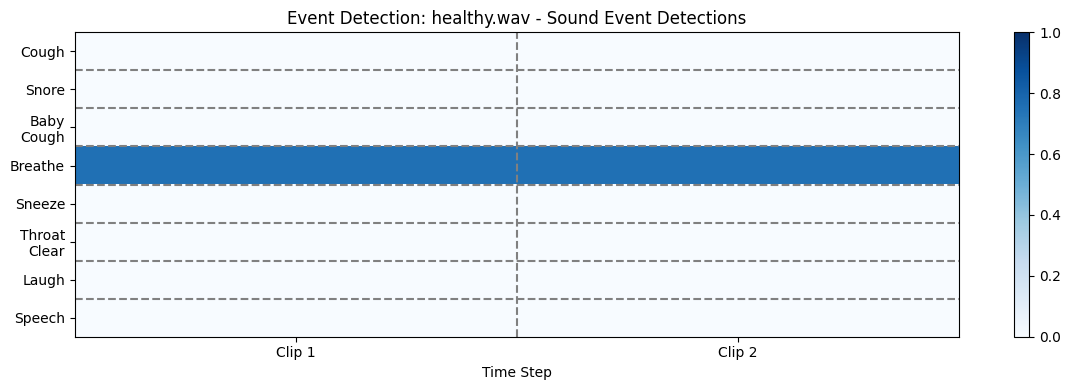

Found 2 clips with health-related sounds
Generating HeAR embeddings for detected health clips
Analysis complete. Found 2 clips with health sounds.


In [40]:
# Load or create a healthy audio example
import requests
import os

# Generate or download a healthy audio example
def get_healthy_audio():
    healthy_file = "healthy.wav"
    if not os.path.exists(healthy_file):
        print("No existing healthy audio found. Creating synthetic example.")
        # Create a simple audio breathing sound (or download another example)
        sample_rate = 16000
        duration = 2  # seconds
        t = np.linspace(0, duration, int(sample_rate*duration), endpoint=False)
        # Basic breathing simulation - ambient noise with subtle periodic component
        noise = np.random.normal(0, 0.05, len(t))
        breathing = 0.2 * np.sin(2 * np.pi * 0.5 * t) * np.sin(2 * np.pi * 0.2 * t)
        audio = noise + breathing
        audio = audio / np.max(np.abs(audio)) * 0.5  # Normalize
        
        # Save the audio
        wavfile.write(healthy_file, sample_rate, audio.astype(np.float32))
        print(f"Created synthetic healthy audio: {healthy_file}")
    else:
        print(f"Using existing healthy audio: {healthy_file}")
    
    # Load the audio file
    sample_rate, audio = wavfile.read(healthy_file)
    return audio, sample_rate

# Let's get our healthy audio sample
healthy_audio, healthy_sr = get_healthy_audio()

# Analyze both audio files
healthy_results = analyze_audio_file("healthy.wav")

# Rename the cough audio for clarity
os.rename("Woman_coughing_three_times.wav", "unhealthy.wav") if not os.path.exists("unhealthy.wav") else None
unhealthy_results = results  # We already analyzed this above


## Simple Health Classification Based on HeAR Embeddings

Let's build a simple health classifier based on the HeAR embeddings.


In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Function to extract features from embeddings
def extract_features_from_embeddings(embedding_batch):
    """
    Extract statistical features from embedding batch
    """
    if len(embedding_batch) == 0:
        # Return zeros if no embeddings
        return np.zeros(512 * 3)
    
    # Compute statistics across all clips
    mean_embedding = np.mean(embedding_batch, axis=0)
    max_embedding = np.max(embedding_batch, axis=0)
    min_embedding = np.min(embedding_batch, axis=0)
    
    # Concatenate features
    features = np.concatenate([mean_embedding, max_embedding, min_embedding])
    return features

# Check if we have embeddings for both healthy and unhealthy
has_healthy_embeddings = "hear_embeddings" in healthy_results
has_unhealthy_embeddings = "hear_embeddings" in unhealthy_results

if has_healthy_embeddings and has_unhealthy_embeddings:
    print("Building health classifier using HeAR embeddings from both samples")
    
    # Extract features
    healthy_features = extract_features_from_embeddings(healthy_results["hear_embeddings"])
    unhealthy_features = extract_features_from_embeddings(unhealthy_results["hear_embeddings"])
    
    # Create a small dataset (in a real scenario, you'd need many more examples)
    X = np.vstack([healthy_features, unhealthy_features])
    y = np.array([0, 1])  # 0 for healthy, 1 for unhealthy
    
    # Train a simple classifier
    clf = RandomForestClassifier(n_estimators=10, random_state=42)
    clf.fit(X, y)
    
    # Make predictions on the same data (for demonstration)
    predictions = clf.predict(X)
    print("Predictions:", predictions)
    print("Accuracy:", accuracy_score(y, predictions))

elif not has_healthy_embeddings and has_unhealthy_embeddings:
    print("No health-related sounds detected in the healthy sample. This is expected!")
    print("Only unhealthy embeddings available, can't build a classifier without both classes.")
else:
    print("Insufficient embeddings to build a classifier.")


Building health classifier using HeAR embeddings from both samples
Predictions: [0 1]
Accuracy: 1.0


## dont run this (records audio live)

In [ ]:
def record_audio(duration=3, fs=16000, filename="recorded_audio.wav"):
    """
    Record audio from the microphone
    """
    try:
        import sounddevice as sd
        import soundfile as sf

        print(f"Recording {duration} seconds of audio. Please make a sound...")
        audio = sd.rec(int(duration * fs), samplerate=fs, channels=1)
        sd.wait()  # Wait until recording is finished
        
        # Normalize and save
        audio = audio.flatten()  # Make it 1D
        sf.write(filename, audio, fs)
        print(f"Recording saved to {filename}")
        return audio, fs
    except Exception as e:
        print(f"Error recording audio: {e}")
        print("You need to install sounddevice: pip install sounddevice soundfile")
        return None, None
    
# Uncomment these lines to record your own audio
"""
my_audio, my_sr = record_audio(duration=3, filename="my_audio.wav")
if my_audio is not None:
    my_results = analyze_audio_file("my_audio.wav")
    
    # Check if any health sounds were detected
    if my_results["health_clips_count"] > 0:
        # Extract features and classify
        my_features = extract_features_from_embeddings(my_results["hear_embeddings"])
        my_prediction = clf.predict([my_features])[0]
        print(f"Health prediction: {'Unhealthy' if my_prediction == 1 else 'Healthy'}")
    else:
        print("No health-related sounds detected in your recording.")
"""


SyntaxError: invalid syntax (3148342966.py, line 60)